In [10]:
import numpy as np
import cv2
from debayer.superpixel import debayer_superpixel
from astropy.io import fits
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project
import matplotlib.pyplot as plt
from pathlib import Path


### Set input image; object name for search neighborhood.

In [19]:
center = SkyCoord.from_name("M57")
# fname = r'C:/images/plate-solving-samples/NGC6888/Light_03310_30.0sec_200gain_-0.3C.fit'
# fname = r"C:\images\plate-solving-samples\Bubble Nebula\Flat_03478_30.0sec_300gain_0.0C.fit"
fname = r"C:\code\astrocam\refine_20250830_020759.fit"
print(center, fname)

<SkyCoord (ICRS): (ra, dec) in deg
    (283.39623652, 33.02913425)> C:\code\astrocam\refine_20250830_020759.fit


### Cone search given object sky-coord

In [20]:
import itertools

def cone_search_stardata(skymap: SkyMap, center: SkyCoord, fov_deg: float):
  stars = []
  for star in skymap.coneSearch(center, fov_deg):
    if 'mag' in star and star['mag'] < 11:
      s_coord = SkyCoord(star['ra'] * u.degree, star['dec'] * u.degree, frame=ICRS)
      x, y = project(s_coord.ra.degree, s_coord.dec.degree, center.ra.degree, center.dec.degree, 0)
      stars.append({
        "id": star["_id"], 
        "cluster_cx": x, "cluster_cy": y, 
        "ra": s_coord.ra.degree, "dec": s_coord.dec.degree,
        "mag": star["mag"]
      })
  df_ref = pd.DataFrame(stars)
  return df_ref

with SkyMap() as sm:
  df_ref = cone_search_stardata(sm, center, fov_deg=5.0)

### Plot of stars in the neighborhood returned by MongoDB

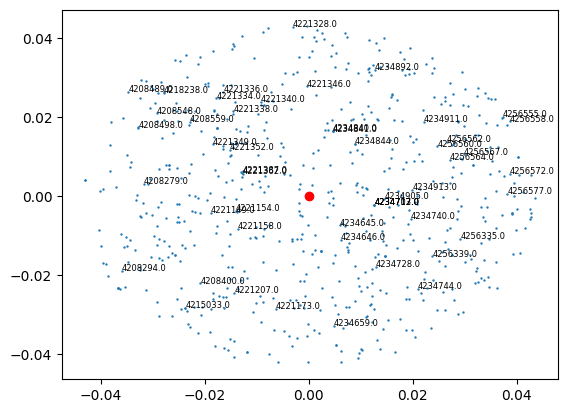

In [21]:
plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy, s=0.5)
for i in range(min(50,len(df_ref))):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')

plt.show()

In [22]:
df_ref.head()

,id,cluster_cx,cluster_cy,ra,dec,mag
0,4234740,0.019677,-0.005801,284.735927,32.689556,3.236923
1,4221387,-0.012773,0.005874,282.519980,33.362669,3.340769
2,4221158,-0.013619,-0.008284,282.470489,32.551060,5.259750
3,4234707,0.012609,-0.002180,284.256708,32.901270,5.430000
4,4256339,0.023748,-0.015240,285.003440,32.145513,5.481625


### Read image and run star matching

In [23]:
with fits.open(fname) as f:
    ph = f[0]
    img = ph.data
    img = np.expand_dims(img, axis=2)
    # img16 = debayer_superpixel(img)
    img16 = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2BGR) # RGGB pattern

assert(img16.dtype == np.uint16)
assert(len(img16.shape) == 3)
assert(img16.shape[2] == 3)
img16 = cv2.cvtColor(img16, cv2.COLOR_BGR2GRAY)
img8 = ((img16 / np.iinfo(np.uint16).max) *np.iinfo(np.uint8).max).astype(np.uint8)
numStars = 20
img_disp = cv2.equalizeHist(img8)
star_img, df_tgt = StarFinder().find_stars(img8=np.squeeze(img8), img16=np.squeeze(img16), topk=numStars)

# votes, vVotingPairs = StarMatcher().matchStars(df_ref, df_tgt, return_merged=False)


fitgaussian2d on 20 images took 0.16 sec; avg: 0.008069 sec


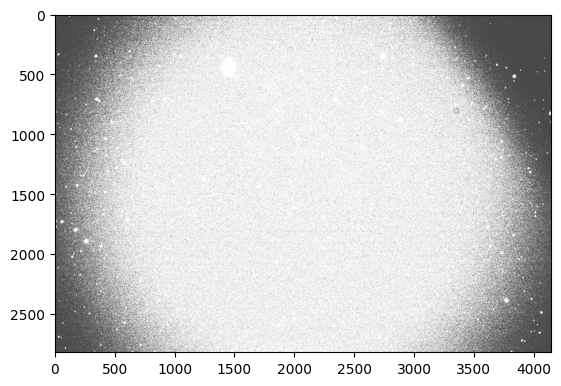

In [24]:
plt.imshow(img_disp, cmap='gray')

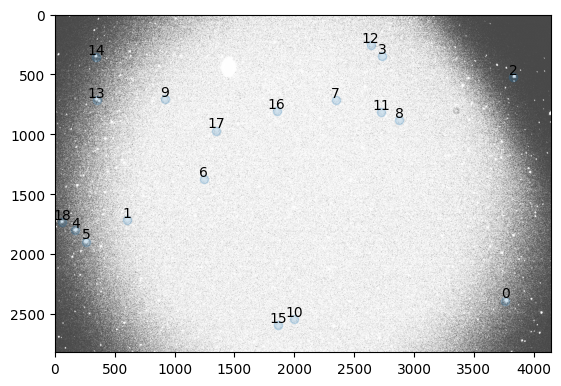

In [25]:
plt.imshow(img_disp, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2)
for idx, tgt in df_tgt.iterrows():
  plt.text(tgt.cluster_cx, tgt.cluster_cy, idx, va='bottom', ha='center', c='black')

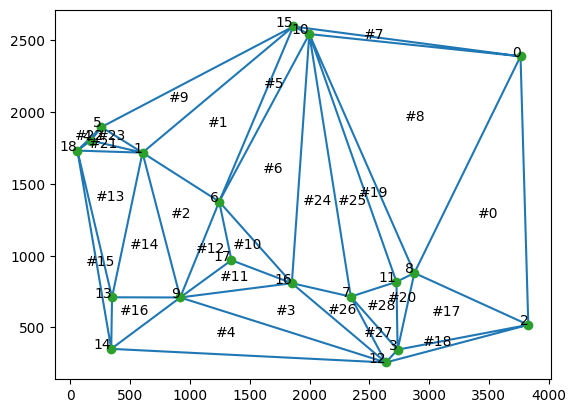

In [26]:
from scipy.spatial import Delaunay
import numpy as np
points = np.array(df_tgt.apply(lambda x: [x.cluster_cx, x.cluster_cy], axis=1).to_list())
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for j, p in enumerate(points):
    plt.text(p[0]-0.03, p[1]+0.03, j, ha='right') # label the points
for j, s in enumerate(tri.simplices):
    p = points[s].mean(axis=0)
    plt.text(p[0], p[1], f'#{j}', ha='center') # label triangles

plt.show()

In [27]:
m = StarMatcher()

tri_tgt = pd.DataFrame(m._getVertexSortedTriangles(df_tgt, itertools.combinations(df_tgt.index, 3), fov_deg=None))

# tri_ref =  m._getVertexSortedDelaunayTriangles(df_ref, fov_deg=1.0)


# tri_ref = []
# for mag_lim in range(int(df_ref.mag.min())+1, int(df_ref.mag.max())+2, 1):
#   df = df_ref[df_ref.mag <= mag_lim]
#   print(mag_lim, len(df))
#   if len(df) < 3: continue
#   tri_ref.append(m._getVertexSortedDelaunayTriangles(df, fov_deg=1.0))
# tri_ref = pd.concat(tri_ref)


D = None
added_triangles = set()
vTriangles = []
initial_points = []
pt_idx = []
for mag in range(int(df_ref.mag.min()), int(df_ref.mag.max())+1, 1):
  df = df_ref[(df_ref.mag >= mag) & (df_ref.mag < mag+1)]

  points = []
  for idx, r in df.iterrows():
    points.append([r.cluster_cx, r.cluster_cy])
    pt_idx.append(idx)

  if D is None:
    if len(initial_points) < 4:
      initial_points.extend(points)
    
    if len(initial_points) >= 4:
      D = Delaunay(initial_points, incremental=True)
  else:
    D.add_points(points)

    print(mag, len(df))
    if len(df) < 3: continue

    pt_indices = []
    for x, y, z in D.simplices:
      a, b, c = pt_idx[x], pt_idx[y], pt_idx[z]
      if (a,b,c) not in added_triangles:
        added_triangles.add((a, b, c))
        pt_indices.append([a, b, c])

    vTriangles.extend(m._getVertexSortedTriangles(df_ref, pt_indices, fov_deg=1.0))

vTriangles = sorted(vTriangles, key=lambda x: x["fX"])
tri_ref = pd.DataFrame(vTriangles)

print(f"Ref triangles: {len(tri_ref)}, Tgt triangles: {len(tri_tgt)}")

6 4
7 26
8 53
9 168
10 406
Ref triangles: 1832, Tgt triangles: 969


In [28]:
tri_ref

,A,B,C,fX,fY
0,130,228,125,0.000057,1.000000
1,228,130,369,0.000092,0.999991
2,103,258,7,0.000123,0.999983
3,206,126,28,0.000124,0.999930
4,126,206,555,0.000140,0.999918
...,...,...,...,...,...
1827,1,138,99,0.951146,0.967356
1828,27,71,24,0.955821,0.991349
1829,179,247,198,0.957087,0.994003
1830,276,325,444,0.963380,0.980848


In [29]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,273,3764.347985,2389.395604,17.000977,18.000977,17.394583,18.008105,"[3746, 2371, 3783, 2408]",619433,9868,7.337609,6.262164
1,256,603.492188,1718.062500,18.000977,16.000977,16.261025,20.396669,"[585, 1701, 622, 1736]",445631,7039,7.105840,7.797878
2,254,3829.397638,518.377953,15.000977,19.000977,19.323816,16.131538,"[3813, 499, 3846, 538]",135637,2200,23.096166,19.381770
3,252,2736.702381,345.579365,15.000977,18.000977,19.966139,16.066948,"[2720, 327, 2753, 364]",89780,1516,6.287396,6.172198
4,234,171.440171,1802.286325,15.000977,17.000977,17.871597,17.001008,"[155, 1784, 188, 1821]",467279,7285,24.103172,21.491332
5,219,259.525114,1896.164384,15.000977,15.000977,15.746959,17.646818,"[243, 1880, 276, 1913]",491129,7678,7.203119,6.608750
6,216,1244.782407,1376.722222,16.000977,15.000977,15.286551,19.491394,"[1227, 1361, 1262, 1392]",356695,5629,5.919202,6.514321
7,190,2344.868421,714.852632,14.000977,14.000977,16.375705,14.718885,"[2330, 699, 2359, 730]",186030,2933,4.906549,4.422319
8,177,2876.638418,879.892655,14.000977,14.000977,15.466216,13.639545,"[2862, 865, 2891, 894]",228639,3600,6.292644,5.456215
9,176,918.954545,709.147727,15.000977,12.000977,13.364590,16.221634,"[903, 696, 934, 723]",183602,2889,24.351017,28.395277


In [30]:
tri_tgt

,A,B,C,fX,fY
0,4,5,2,0.033206,0.987048
1,18,4,2,0.033405,0.978735
2,18,4,0,0.035162,0.967445
3,4,5,0,0.035361,0.972201
4,4,5,3,0.043638,0.990658
...,...,...,...,...,...
964,11,0,15,0.952223,0.966697
965,4,13,6,0.958082,0.967027
966,7,3,8,0.967004,0.991993
967,17,13,1,0.976897,0.984410


## Triangle matching

In [31]:
TRIANGLETOLERANCE = 1e-2

txs = []

for tgt in tri_tgt.itertuples():
    similar_triangles = tri_ref[
        (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
        (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2) &
        (tri_ref.fY >= tgt.fY - TRIANGLETOLERANCE/2) &
        (tri_ref.fY <= tgt.fY + TRIANGLETOLERANCE/2)
    ]
    for r in similar_triangles.itertuples():
        ra = df_ref.iloc[r.A][['cluster_cx', 'cluster_cy']].tolist()
        rb = df_ref.iloc[r.B][['cluster_cx', 'cluster_cy']].tolist()
        rc = df_ref.iloc[r.C][['cluster_cx', 'cluster_cy']].tolist()
        ta = df_tgt.iloc[tgt.A][['cluster_cx', 'cluster_cy']].tolist()
        tb = df_tgt.iloc[tgt.B][['cluster_cx', 'cluster_cy']].tolist()
        tc = df_tgt.iloc[tgt.C][['cluster_cx', 'cluster_cy']].tolist()
        src = np.stack([ra, rb, rc], dtype=np.float32)
        dst = np.stack([ta, tb, tc], dtype=np.float32)
        tx = cv2.getAffineTransform(src, dst)
        mapped = False
        for i, (e,c) in enumerate(txs):
            if np.linalg.norm(tx - e) < 100:
                txs[i][1] += 1
                mapped = True
                # print(tx,r.A, r.B, r.C, tgt.A, tgt.B, tgt.C)
                break
        if not mapped:
            txs.append([tx, 1])


In [32]:
tx, num_matches = sorted(txs, key=lambda x: x[1], reverse=True)[0]

In [33]:

from itertools import product

vertex_sorted = True
down_votes = True
absolute_similar = True
vote_with_conf = True


for TRIANGLETOLERANCE in [
        # 1e-5, 5e-5, 1e-4, 2e-4,
        # 3e-4, 5e-4, 7e-4, 1e-3,
        # 2e-3, 
        5e-3, 7e-3, 1e-2]:
    votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.float32)

    for tgt in tri_tgt.itertuples():
        if absolute_similar:
            similar_triangles = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2) &
                (tri_ref.fY >= tgt.fY - TRIANGLETOLERANCE/2) &
                (tri_ref.fY <= tgt.fY + TRIANGLETOLERANCE/2)
            ]
        else:
            ref_matches = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2)]
            similar_triangles = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]

        for ref in similar_triangles.itertuples():
            if vote_with_conf:
                err = ((ref.fX-tgt.fX)**2 + (ref.fY-tgt.fY)**2)
                upvote = 1/(np.exp(err*100))
                downvote = upvote / 4
            else:
                upvote = 1
                downvote = 1/4

            if vertex_sorted:
                # expect matched ABC vertices
                votes[ref.A, tgt.A] += upvote
                votes[ref.B, tgt.B] += upvote
                votes[ref.C, tgt.C] += upvote

                if down_votes:
                    votes[ref.A, tgt.B] -= downvote
                    votes[ref.A, tgt.C] -= downvote

                    votes[ref.B, tgt.A] -= downvote
                    votes[ref.B, tgt.C] -= downvote
                    
                    votes[ref.C, tgt.A] -= downvote
                    votes[ref.C, tgt.B] -= downvote
            else:
                # expect unordered star indices s1, s2, s3
                for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
                    votes[int(a), b] += upvote
    if np.sum(votes) > 10:
        break
    
print(f"TRIANGLETOLERANCE: {TRIANGLETOLERANCE}")
print(f"Total triangle comparisons: {len(tri_ref) * len(tri_tgt)}")
print(f"Total votes: {np.sum(votes)}, hit-ratio: {np.sum(votes) / (len(tri_ref) * len(tri_tgt))}")


TRIANGLETOLERANCE: 0.005
Total triangle comparisons: 1775208
Total votes: 275.8818359375, hit-ratio: 0.00015540816821157932


In [34]:
with open('votes.csv', 'wt') as f:  
  arr = votes.flatten()
  for i in range(arr.shape[0]):
    f.write(f"{arr[i]}\n")


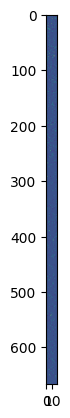

In [35]:
plt.imshow(votes)

(array([9.0000e+00, 9.2400e+02, 1.1885e+04, 8.0000e+00, 1.7900e+02,
        3.0700e+02, 4.0000e+00, 2.2000e+01, 0.0000e+00, 2.0000e+00]),
 array([-0.99947685, -0.59969151, -0.19990617,  0.19987923,  0.59966451,
         0.99944979,  1.39923525,  1.79902053,  2.19880581,  2.59859109,
         2.99837661]),
 <BarContainer object of 10 artists>)

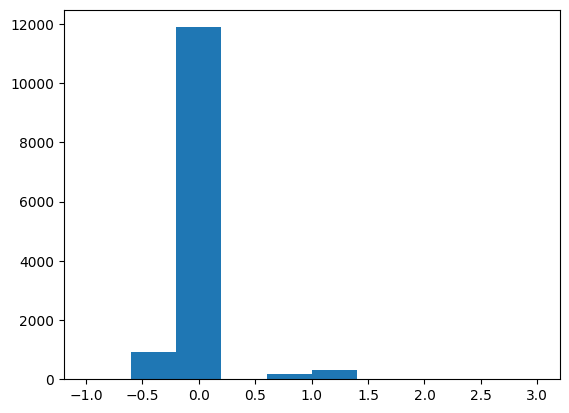

In [36]:
plt.hist(votes.flatten())

In [37]:
# Produce sorted list of star pairs with highest votes
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [38]:
cutoff = votes.max() / 4
# print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

matches = []
for vp in topVotePairs:
    s1, s2 = vp
    # if s1 == 0 or s2 == 0: # WHY ?
    #     continue
    if np.argmax(votes[:, s2]) == s1 and np.argmax(votes[s1, :]) == s2:
        matches.append((s1, s2))

df_tgt['starno'] = None
df_tgt['votes'] = None
for m1, m2 in matches:
    df_tgt.loc[m2, 'starno'] = m1
    df_tgt.loc[m2, 'votes'] = votes[m1, m2]

In [39]:
d = []
# n = []
for i in range(len(df_tgt)):
    m = votes[:,i]
    ave = (m.sum() - m.max())/(len(m)-1)
    d.append((m.max()-ave)/ave)
    # n.append(len(np.argwhere(m > 2 * ave)))
print(d)
# print(n)
# plt.plot(m)
# plt.plot(np.arange(0, len(m)), np.full(len(m), ave))


[np.float32(123.85444), np.float32(125.876236), np.float32(125.906334), np.float32(114.84702), np.float32(80.80802), np.float32(73.02341), np.float32(59.57098), np.float32(132.26852), np.float32(125.82171), np.float32(147.06316), np.float32(84.9673), np.float32(94.112434), np.float32(97.6791), np.float32(123.85386), np.float32(50.247986), np.float32(44.953976), np.float32(149.40257), np.float32(82.29198), np.float32(77.34867)]


## Matched stars

In [40]:
# display(df_tgt[~df_tgt.starno.isnull()])
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes
0,273,3764.347985,2389.395604,17.000977,18.000977,17.394583,18.008105,"[3746, 2371, 3783, 2408]",619433,9868,7.337609,6.262164,248,2.998377
1,256,603.492188,1718.062500,18.000977,16.000977,16.261025,20.396669,"[585, 1701, 622, 1736]",445631,7039,7.105840,7.797878,92,1.999372
2,254,3829.397638,518.377953,15.000977,19.000977,19.323816,16.131538,"[3813, 499, 3846, 538]",135637,2200,23.096166,19.381770,292,1.999976
3,252,2736.702381,345.579365,15.000977,18.000977,19.966139,16.066948,"[2720, 327, 2753, 364]",89780,1516,6.287396,6.172198,76,1.999424
4,234,171.440171,1802.286325,15.000977,17.000977,17.871597,17.001008,"[155, 1784, 188, 1821]",467279,7285,24.103172,21.491332,16,1.749442
5,219,259.525114,1896.164384,15.000977,15.000977,15.746959,17.646818,"[243, 1880, 276, 1913]",491129,7678,7.203119,6.608750,70,1.999741
6,216,1244.782407,1376.722222,16.000977,15.000977,15.286551,19.491394,"[1227, 1361, 1262, 1392]",356695,5629,5.919202,6.514321,206,0.999979
7,190,2344.868421,714.852632,14.000977,14.000977,16.375705,14.718885,"[2330, 699, 2359, 730]",186030,2933,4.906549,4.422319,543,1.999976
8,177,2876.638418,879.892655,14.000977,14.000977,15.466216,13.639545,"[2862, 865, 2891, 894]",228639,3600,6.292644,5.456215,199,1.998427
9,176,918.954545,709.147727,15.000977,12.000977,13.364590,16.221634,"[903, 696, 934, 723]",183602,2889,24.351017,28.395277,17,1.999692


##  Solved or not

In [41]:
print(f"Solver votes: {df_tgt.votes.sum()}; matches: {(~df_tgt.starno.isnull()).sum()} stars")

if (~df_tgt.starno.isnull()).sum() >= 3:
  print("Solved")
else:
  print("Failed")

Solver votes: 34.48903274536133; matches: 18 stars
Solved


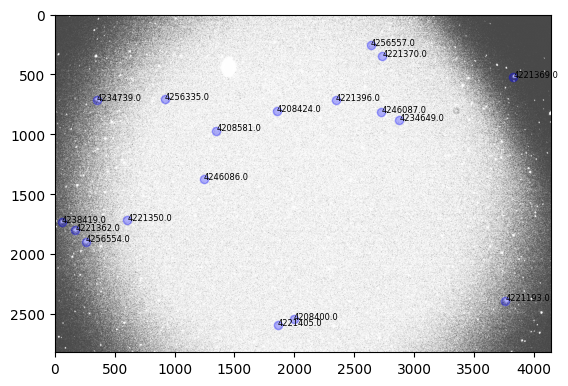

In [42]:
plt.imshow(img_disp, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    plt.scatter(star.cluster_cx, star.cluster_cy, color='blue', alpha=0.3)
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='black')

## Calculate transformation matrix
From known star mapping to image, compute affine transformation to map database projection to image

In [43]:
img_stars = df_tgt[~df_tgt.starno.isnull()][['starno','cluster_cx', 'cluster_cy', 'votes']]
img_ref_stars = df_ref[['id','cluster_cx', 'cluster_cy', 'ra', 'dec']].join(img_stars.set_index('starno'), rsuffix='r', how='right')
display(img_ref_stars)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
248,4221193,-0.000202,-0.041955,283.382815,30.624574,3764.347985,2389.395604,2.998377
92,4221350,-0.017657,0.017361,282.175606,34.018035,603.492188,1718.062500,1.999372
292,4221369,-0.003566,0.005473,283.151682,33.342479,3829.397638,518.377953,1.999976
76,4221370,-0.001606,0.003158,283.286229,33.210025,2736.702381,345.579365,1.999424
16,4221362,-0.012658,0.005685,282.527934,33.351841,171.440171,1802.286325,1.749442
70,4256554,0.028749,0.018670,285.385447,34.083334,259.525114,1896.164384,1.999741
206,4246086,0.002443,-0.013825,283.561749,32.236893,1244.782407,1376.722222,0.999979
543,4221396,-0.001912,0.001714,283.265450,33.127257,2344.868421,714.852632,1.999976
199,4234649,0.007785,-0.011849,283.924265,32.349098,2876.638418,879.892655,1.998427


In [44]:
matched_star_triple = img_ref_stars.sort_values('votes', ascending=False)[:3]
display(matched_star_triple)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
248,4221193,-0.000202,-0.041955,283.382815,30.624574,3764.347985,2389.395604,2.998377
75,4234739,0.019548,-0.009534,284.724007,32.475806,348.856164,710.376712,2.998158
543,4221396,-0.001912,0.001714,283.265450,33.127257,2344.868421,714.852632,1.999976


In [45]:
src = np.array([(row.cluster_cx, row.cluster_cy) for _, row in matched_star_triple.iterrows()], dtype=np.float32)
dst = np.array([(row.cluster_cxr, row.cluster_cyr) for _, row in matched_star_triple.iterrows()], dtype=np.float32)

In [46]:
import cv2
tx = cv2.getAffineTransform(src, dst)
print(tx)

[[-112354.1722601   -36905.24205802    2193.33459437]
 [ -20732.13450109  -39158.20149555     742.32760581]]


## Apply transform with dot-product

In [47]:
df_ref[['img_cx', 'img_cy']] = df_ref.apply(lambda r: pd.Series(np.dot(tx, [r.cluster_cx, r.cluster_cy, 1])).astype(np.int32), axis=1)

## Applyig transform with cv2.transform

In [48]:
# pts = np.array([[(r.cluster_cx, r.cluster_cy) for _,r in df_ref.iterrows()]], dtype=np.float32)
# print(pts[0,0,:])
# tx_pts = cv2.transform(pts, tx)
# print(tx_pts[0,0,:])
# print(pts.shape, tx_pts.shape)
# display(np.hstack([pts[0], tx_pts[0]])[0:5])

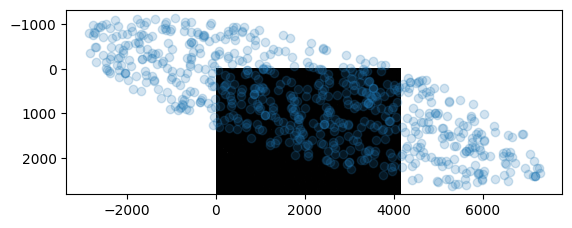

In [49]:
# pts = tx * pts
plt.imshow(img8, cmap='gray')
# plt.scatter(tx_pts[0, :, 0], tx_pts[0, :, 1], alpha=0.2)
plt.scatter(df_ref.img_cx, df_ref.img_cy, alpha=0.2)

# Reassign stars


In [50]:

def dist(x1,y1, x2,y2):
  return np.sqrt((y2-y1)**2+(x2-x1)**2)
def reassign(t):
  x = df_ref.apply(lambda r: pd.Series([dist(t.cluster_cx, t.cluster_cy, r.img_cx, r.img_cy)]), axis=1)[0]
  m = x.min()
  if m < 25:
    idx = x.argmin()
    return pd.Series([idx, df_ref.iloc[idx].ra, df_ref.iloc[idx].dec])
  else:
    return pd.Series([None, None, None])
df_tgt[['starno', 'ra', 'dec']] = df_tgt.apply(reassign, axis=1)


In [51]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes,ra,dec
0,273,3764.347985,2389.395604,17.000977,18.000977,17.394583,18.008105,"[3746, 2371, 3783, 2408]",619433,9868,7.337609,6.262164,248.0,2.998377,283.382815,30.624574
1,256,603.492188,1718.062500,18.000977,16.000977,16.261025,20.396669,"[585, 1701, 622, 1736]",445631,7039,7.105840,7.797878,NaN,1.999372,NaN,NaN
2,254,3829.397638,518.377953,15.000977,19.000977,19.323816,16.131538,"[3813, 499, 3846, 538]",135637,2200,23.096166,19.381770,NaN,1.999976,NaN,NaN
3,252,2736.702381,345.579365,15.000977,18.000977,19.966139,16.066948,"[2720, 327, 2753, 364]",89780,1516,6.287396,6.172198,NaN,1.999424,NaN,NaN
4,234,171.440171,1802.286325,15.000977,17.000977,17.871597,17.001008,"[155, 1784, 188, 1821]",467279,7285,24.103172,21.491332,NaN,1.749442,NaN,NaN
5,219,259.525114,1896.164384,15.000977,15.000977,15.746959,17.646818,"[243, 1880, 276, 1913]",491129,7678,7.203119,6.608750,NaN,1.999741,NaN,NaN
6,216,1244.782407,1376.722222,16.000977,15.000977,15.286551,19.491394,"[1227, 1361, 1262, 1392]",356695,5629,5.919202,6.514321,NaN,0.999979,NaN,NaN
7,190,2344.868421,714.852632,14.000977,14.000977,16.375705,14.718885,"[2330, 699, 2359, 730]",186030,2933,4.906549,4.422319,543.0,1.999976,283.265450,33.127257
8,177,2876.638418,879.892655,14.000977,14.000977,15.466216,13.639545,"[2862, 865, 2891, 894]",228639,3600,6.292644,5.456215,NaN,1.998427,NaN,NaN
9,176,918.954545,709.147727,15.000977,12.000977,13.364590,16.221634,"[903, 696, 934, 723]",183602,2889,24.351017,28.395277,NaN,1.999692,NaN,NaN


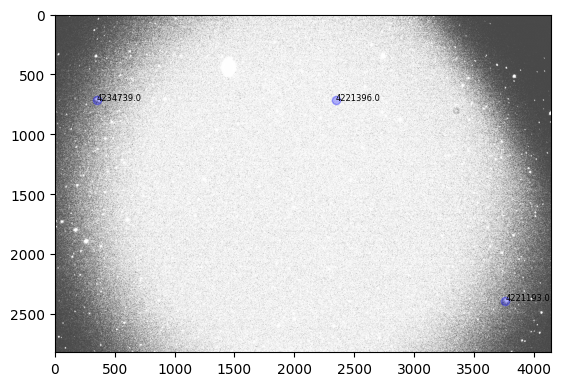

In [52]:
plt.imshow(img_disp, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.scatter(star.cluster_cx, star.cluster_cy, color='blue', alpha=0.3)
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='black')

## Map pixel coordinated to RA,DEC
Use linear regression to fit a function to map pixel coordinates to RA,DEC.
Useful to find RA, DEC of image center.

In [53]:
from sklearn.linear_model import LinearRegression

nonantgt = df_tgt[ (~df_tgt.ra.isna()) & (~df_tgt.dec.isna())]
X = nonantgt[['cluster_cx', 'cluster_cy']]
y = nonantgt[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict([[img8.shape[1]//2, img8.shape[0]//2]])[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (283.94618819, 31.80174188)>
Separation from target: 78.73524556778972


c:\Users\anand\miniconda3\envs\astrocam\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [54]:
df_tgt['name'] = None
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
  df_tgt.loc[idx, 'name'] = df_ref.loc[star.starno].id

In [55]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes,ra,dec,name
0,273,3764.347985,2389.395604,17.000977,18.000977,17.394583,18.008105,"[3746, 2371, 3783, 2408]",619433,9868,7.337609,6.262164,248.0,2.998377,283.382815,30.624574,4221193.0
1,256,603.492188,1718.062500,18.000977,16.000977,16.261025,20.396669,"[585, 1701, 622, 1736]",445631,7039,7.105840,7.797878,NaN,1.999372,NaN,NaN,None
2,254,3829.397638,518.377953,15.000977,19.000977,19.323816,16.131538,"[3813, 499, 3846, 538]",135637,2200,23.096166,19.381770,NaN,1.999976,NaN,NaN,None
3,252,2736.702381,345.579365,15.000977,18.000977,19.966139,16.066948,"[2720, 327, 2753, 364]",89780,1516,6.287396,6.172198,NaN,1.999424,NaN,NaN,None
4,234,171.440171,1802.286325,15.000977,17.000977,17.871597,17.001008,"[155, 1784, 188, 1821]",467279,7285,24.103172,21.491332,NaN,1.749442,NaN,NaN,None
5,219,259.525114,1896.164384,15.000977,15.000977,15.746959,17.646818,"[243, 1880, 276, 1913]",491129,7678,7.203119,6.608750,NaN,1.999741,NaN,NaN,None
6,216,1244.782407,1376.722222,16.000977,15.000977,15.286551,19.491394,"[1227, 1361, 1262, 1392]",356695,5629,5.919202,6.514321,NaN,0.999979,NaN,NaN,None
7,190,2344.868421,714.852632,14.000977,14.000977,16.375705,14.718885,"[2330, 699, 2359, 730]",186030,2933,4.906549,4.422319,543.0,1.999976,283.265450,33.127257,4221396.0
8,177,2876.638418,879.892655,14.000977,14.000977,15.466216,13.639545,"[2862, 865, 2891, 894]",228639,3600,6.292644,5.456215,NaN,1.998427,NaN,NaN,None
9,176,918.954545,709.147727,15.000977,12.000977,13.364590,16.221634,"[903, 696, 934, 723]",183602,2889,24.351017,28.395277,NaN,1.999692,NaN,NaN,None
